In [34]:
import sys
sys.path.insert(0, '..')
import dognet

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle,Ellipse

%matplotlib inline

import torch
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import roc_curve, auc

### Load data

In [57]:
req_channels=['synapsin-1', 'PSD-95', 'VGLUT1']
rep21 = dognet.data.Prism("../datasets/prism17/rep2-1/Rep2-1.npz",req_channels=req_channels)
rep31 = dognet.data.Prism("../datasets/prism17/rep3-1/Rep3-1.npz",req_channels=req_channels)
rep31_map = dognet.data.Prism("../datasets/prism17/rep3-1/Rep3-1.npz",req_channels=['MAP2'])

#train
rep21_anno = rep21.get_annotations("../datasets/prism17/rep2-1/annotation_data_mbs_final.r2-1.mat")\
+ rep21.get_annotations("../datasets/prism17/rep2-1/annotation_data_smg.r2-1.mat")

#test
rep31_anno = rep31.get_annotations("../datasets/prism17/rep3-1/annotation_data_mbs.r3-1.mat")\
+ rep31.get_annotations("../datasets/prism17/rep3-1/annotation_data_smg.r3-1.mat")\
+ rep31.get_annotations("../datasets/prism17/rep3-1/annotation_data_ed.r3-1.mat")

['synapsin-1', 'PSD-95', 'VGLUT1', 'bassoon', 'MAP2']
['synapsin-1', 'PSD-95', 'VGLUT1', 'bassoon', 'MAP2']
['synapsin-1', 'PSD-95', 'VGLUT1', 'bassoon', 'MAP2']


In [3]:
meanx = rep21.data.mean(axis=(0,2,3))
minx = rep21.data.min(axis=(0,2,3))
maxx = rep21.data.max(axis=(0,2,3))

def get_normparams(data):
    return data.mean(axis=(0,2,3)),data.min(axis=(0,2,3)),data.max(axis=(0,2,3))

def normalize(im,norm_data):
    meanx,minx,maxx = norm_data
    x = np.copy(im.astype(np.float32))
    x = x.transpose(1,2,0)
    x = (x - meanx - minx)/(maxx - minx)
    return x.transpose(2,0,1)

def inference(net,image,get_intermediate=False):
    x = np.expand_dims(image,0)
    vx = Variable(torch.from_numpy(x).float()).cuda()
    
    res,inter = net(vx)
    if get_intermediate:
        return res.data.cpu().numpy(),inter.data.cpu().numpy()
    return res.data.cpu().numpy()

def draw_proccessed(x,image):
    y = inference(net,normalize(x,get_normparams(rep21.data)))
    
    fig,ax = plt.subplots(1,1,figsize=(20,10))
   
    plt.setp(ax, xticks=[], yticks=[])
    plt.imshow(image,cmap='gray',interpolation='bilinear')
    return ax,y

from skimage.draw import circle
def make_labels(img,xs,ys,radius=5):
    labels = np.zeros(img.shape[1:])
    for xv,yv in zip(xs,ys):
        rr,cc = circle(xv,yv,radius,labels.shape)
        
        labels[rr,cc]=1
    return labels

def estimate(net,test_set,s=2.):
    mf1=[]
    mprec =[]
    mrec = []
    mauc=[]
             
    for test in test_set:
        y = inference(net,normalize(test.image,get_normparams(rep21.data)))
        xx,yy,_ = dognet.find_peaks(y[0,0],3)
        dog_pts = np.array([yy,xx]).transpose(1,0)
        
        #plt.imshow(test.image[0])
        xs,ys = test.x,test.y
        gt_pts = np.array([xs,ys]).transpose(1,0)
        y_gt = make_labels(test.image,ys,xs,radius=1.5)
       
        fpr, tpr, thresholds = roc_curve(y_gt.flatten(),y[0,0].flatten())
        mauc.append(auc(fpr, tpr))
       
        prec = 0
        rec =0
        f1 = 0 
        if len(xx)>0:
            prec,rec,f1,_ = dognet.get_metric(gt_pts,dog_pts,s=s)
        mf1.append(f1)
        mprec.append(prec)
        mrec.append(rec)
    return np.mean(mf1),np.mean(mprec),np.mean(mrec),np.mean(mauc)

### Train DoGNet

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = dognet.SimpleAnisotropic(3,11,2,learn_amplitude=False)
print(dognet.get_n_params(net))
gen = dognet.create_generator([normalize(r.image,get_normparams(rep21.data)) for r in rep21_anno[:2]],
                                                 [l.labels for l in rep21_anno[:2]])

net = net.to(device)

ff = []

#net.weights_init()
#net,errors = dognet.train_routine(net,gen,n_iter=2000,margin=5)
#print(estimate(net,rep31_anno))
for i in range(1):
    net.weights_init()
    net,errors = dognet.train_routine(net,gen,n_iter=2000,margin=5,lr=0.001,loss="softdice",verbose=True)
    ff.append(estimate(net,rep31_anno))
print(np.mean([list(f) for f in ff],0))


46
(tensor([ 167.3377], device='cuda:0'), (10, 1, 64, 64), 4096, 228.0, 1.0)
<function soft_dice_loss at 0x7f11fa55ce60>
Training started!
[====================] 100%
Training finished!
[0.77832789 0.75488392 0.80416667 0.90204297]


In [14]:
torch.save(net.state_dict(), 'Simple_Anisotropic_4_11_2_prism17.t7')
np.save("prism17_normparams.npy",get_normparams(rep21.data))

In [12]:
gen = dognet.create_generator([normalize(r.image,get_normparams(rep21.data)) for r in rep21_anno[:2]],
                                                 [l.labels for l in rep21_anno[:2]])
net = dognet.SimpleIsotropic(len(req_channels),11,4,learn_amplitude=False,return_intermediate=True)
net.weights_init()
if torch.cuda.is_available():
    print('with CUDA')
    net = net.cuda()
else:
    print('CUDA is not detected, running on CPU')
net,errors = dognet.train_routine(net,gen,n_iter=2000,margin=5)
print(estimate(net,rep31_anno))

with CUDA
(tensor([ 135.1773], device='cuda:0'), (10, 1, 64, 64), 4096, 282.0, 1.0)
BCELoss()
Training started!
[====================] 100%
Training finished!
(0.7450570585110317, 0.6917452710870284, 0.8082191780821918, 0.9209048966881167)


### Estimate perforamce agains human experts

In [15]:
s = 3.
print('dognet vs mbs',estimate(net,[rep31_anno[0]],s))
print('dognet vs smg',estimate(net,[rep31_anno[1]],s))
print('dognet vs ed',estimate(net,[rep31_anno[2]],s))


mbs_pts = np.array([rep31_anno[0].x,rep31_anno[0].y]).transpose(1,0)
smg_pts = np.array([rep31_anno[1].x,rep31_anno[1].y]).transpose(1,0)
ed_pts = np.array([rep31_anno[2].x,rep31_anno[2].y]).transpose(1,0)
prec,rec,f1,_ = dognet.get_metric(smg_pts,mbs_pts,s=s)
print('mbs vs smg',f1,prec,rec)
prec,rec,f1,_ = dognet.get_metric(smg_pts,ed_pts,s=s)
print('ed vs smg',f1,prec,rec)
prec,rec,f1,_ = dognet.get_metric(mbs_pts,ed_pts,s=s)
print('ed vs mbs',f1,prec,rec)


('dognet vs mbs', (0.8187134502923977, 0.7692307692307693, 0.875, 0.9041114246342856))
('dognet vs smg', (0.8518518518518519, 0.8414634146341463, 0.8625, 0.9122086216582639))
('dognet vs ed', (0.8466257668711658, 0.8313253012048193, 0.8625, 0.8898088742076916))
('mbs vs smg', 0.8208092485549133, 0.8658536585365854, 0.7802197802197802)
('ed vs smg', 0.812121212121212, 0.8170731707317073, 0.8072289156626506)
('ed vs mbs', 0.7701149425287357, 0.7362637362637363, 0.8072289156626506)


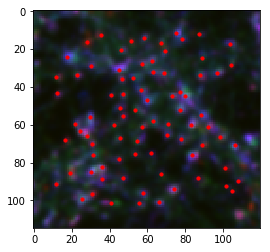

In [16]:
iii=np.copy(rep31_anno[1].image[:3].transpose(1,2,0)).astype(np.float32)
#iii[iii>10000]=10000
plt.imshow((iii-iii.min())/(np.max(iii)-iii.min()))
plt.scatter(rep31_anno[1].x,rep31_anno[1].y,s=10,c='r')

### Display some results

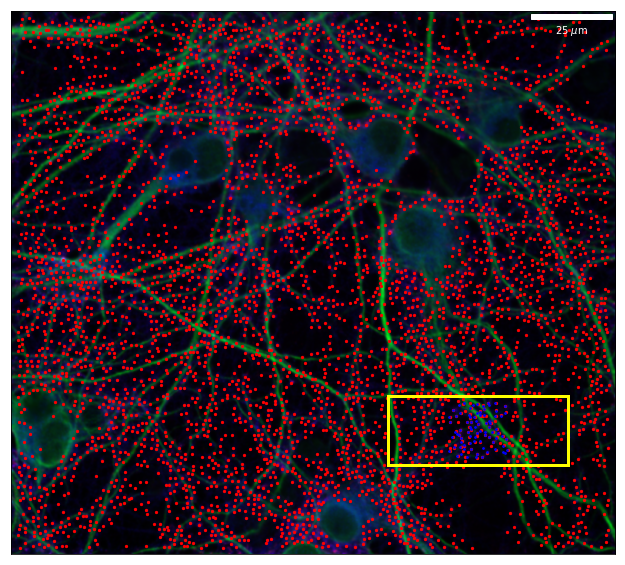

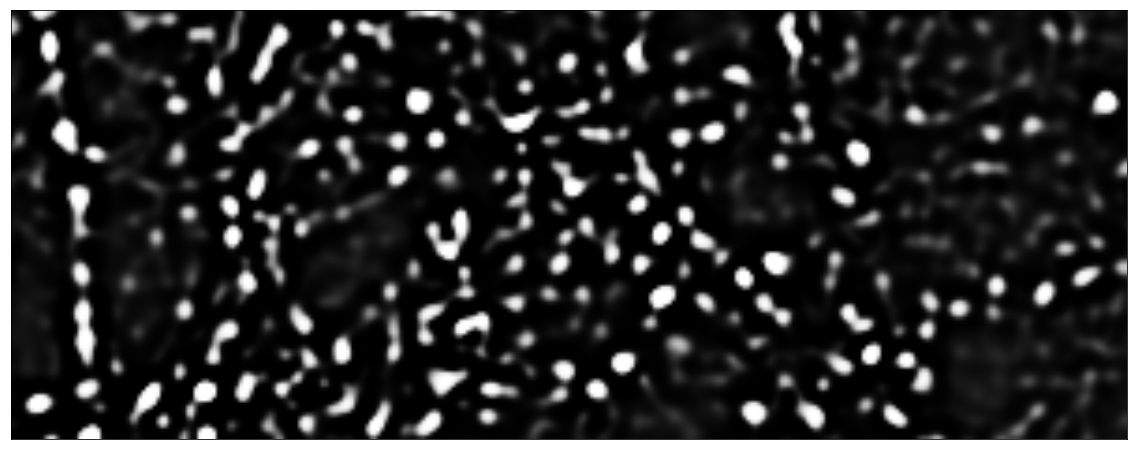

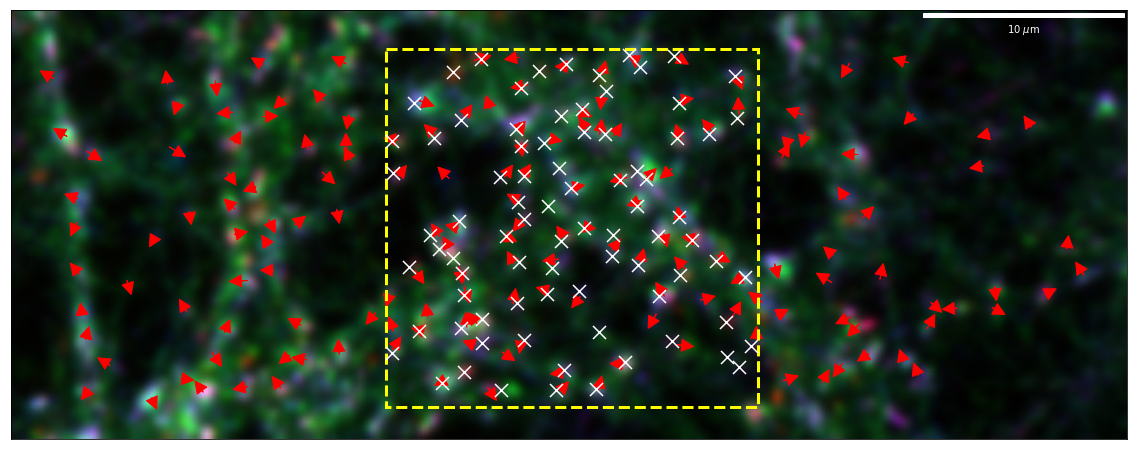

In [17]:
fov = 1
plot_img = np.dstack([rep31.data[fov,req_channels.index('synapsin-1')],
                      rep31_map.data[fov,0],
                     rep31.data[fov,req_channels.index('PSD-95')]])

plot_img = (plot_img-np.min(plot_img,(0,1)))/(np.max(plot_img,(0,1))-np.min(plot_img,(0,1))).astype(np.float)

ax,y = draw_proccessed(rep31.data[fov],plot_img)
xx,yy,_ = dognet.find_peaks(y[0,0],3)
plt.scatter(yy,xx,s=5,c='red')

clip=100
clipx=10

x1 =int(rep31_anno[1].r[1])-clipx
x2 =int(x1+rep31_anno[1].r[3])+clipx*2
y1 =int(rep31_anno[1].r[0])-clip
y2 =int(y1+rep31_anno[1].r[2])+clip*2

plt.scatter(y1+rep31_anno[1].x+clip-10,x1+rep31_anno[1].y+clipx-10,s=3,c='blue')

rect = Rectangle((y1,x1), y2-y1, x2-x1,fill=False,
                 edgecolor="yellow",lw=3)
ax.add_artist(rect)






plot_img = np.dstack([rep31.data[fov,req_channels.index('synapsin-1'),x1:x2,y1:y2],
                      rep31_map.data[fov,0,x1:x2,y1:y2],
                     rep31.data[fov,req_channels.index('PSD-95'),x1:x2,y1:y2]])

plot_img = np.dstack([rep31.data[fov,req_channels.index('synapsin-1'),x1:x2,y1:y2],
                      rep31.data[fov,req_channels.index('PSD-95'),x1:x2,y1:y2],
                     rep31.data[fov,req_channels.index('VGLUT1'),x1:x2,y1:y2]])



from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1.86e-7,color = 'white',box_alpha=0.0)
ax.add_artist(scalebar)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
plt.setp(axes, xticks=[], yticks=[])
axes.imshow(y[0,0,x1:x2,y1:y2],interpolation='bilinear',cmap='gray')
plt.savefig("prism_prob.png", bbox_inches='tight', pad_inches = 0 ,dpi=300)

plot_img = (plot_img-np.min(plot_img,(0,1)))/(np.max(plot_img,(0,1))-np.min(plot_img,(0,1))).astype(np.float)
ax,y = draw_proccessed(rep31.data[fov][:,x1:x2,y1:y2],plot_img)#rep31_dapi.data[0,1,x1:x2,y1:y2])
scalebar = ScaleBar(1.86e-7,color = 'white',box_alpha=0.0)
ax.add_artist(scalebar)
plt.savefig("prism_org.png", bbox_inches='tight', pad_inches = 0 ,dpi=300)
xx,yy,_ = dognet.find_peaks(y[0,0],3)

syn = dognet.extract_descriptor(rep31.data[fov][req_channels.index('synapsin-1'),x1:x2,y1:y2],
                                xx,yy,window_size=5,get_gaussian=dognet.get_gaussian)
psd = dognet.extract_descriptor(rep31.data[fov][req_channels.index('PSD-95'),x1:x2,y1:y2],
                                xx,yy,window_size=5,get_gaussian=dognet.get_gaussian)

for s,p in zip(syn,psd):
    ax.arrow(s[0],s[1], p[0]-s[0], p[1]-s[1], head_width=3.2, head_length=3.2, fc='r', ec='r')
    
#plt.scatter(yy,xx,s=70,c='r',marker='o',zorder=1)  
plt.scatter(rep31_anno[1].x+clip-10,rep31_anno[1].y+clipx-10,s=170,c='w',marker='x',zorder=10)  
rect = Rectangle((clip,10), rep31_anno[1].r[2], rep31_anno[1].r[3],fill=False,
                 edgecolor="yellow",linestyle='--',lw=3)
ax.add_artist(rect)
plt.savefig("prism_loc.png", bbox_inches='tight', pad_inches = 0 ,dpi=300)

(167, 11)

In [33]:
req_channels

['synapsin-1', 'PSD-95', 'VGLUT1']

(4510, 11)

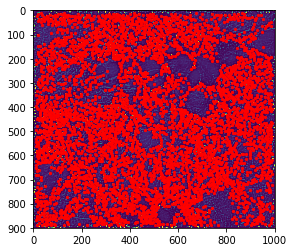

In [32]:
plt.figure()
x = rep31.data[fov]
y = inference(net,normalize(x,get_normparams(rep21.data)))
xx,yy,_ = dognet.find_peaks(y[0,0],3)
plt.imshow(y[0,0])
plt.scatter(yy,xx,s=5,c='red')

syn = dognet.extract_descriptor(x[req_channels.index('synapsin-1')],
                                xx,yy,window_size=5,get_gaussian=dognet.get_gaussian)

np.array(syn).shape

In [9]:
from skimage.io import imsave

for rep,name in zip([rep21,rep31],['rep21','rep31']):
    dm = []
    for fov in range(0,6):
        x = rep.data[fov]
        y = inference(net,normalize(x,get_normparams(rep21.data))) 
        xx,yy,_ = dognet.find_peaks(y[0,0],3)
        imsave("../results/prism_prob_"+name+"_"+str(fov)+".png",y[0,0])
        
        pic = np.copy(x)
        pic = x[:3].transpose(1,2,0).astype(np.float32)
        pic = pic/pic.max()
        #print(pic.max(),pic.min())
        pic[pic>0.8]=0.8
        pic = (pic-np.min(pic,(0,1)))/(np.max(pic,(0,1))-np.min(pic,(0,1))).astype(np.float)
        imsave("../results/prism_org_"+name+"_"+str(fov)+".png",pic)
        for x,y in zip(xx,yy):
            x = int(x)
            y = int(y)
            pic[x-1:x+2,y,0]=1
            pic[x-1:x+2,y,1]=1
            pic[x-1:x+2,y,2]=0
            pic[x,y-1:y+2,0]=1
            pic[x,y-1:y+2,1]=1
            pic[x,y-1:y+2,2]=0
        imsave("../results/prism_loc_"+name+"_"+str(fov)+".png",pic)

/home/vkulikov/.local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


### Export synapse descriptors as CSV file

In [118]:
import pandas as pd
for rep,name in zip([rep21,rep31],['rep21','rep31']):
    dm = []
    for fov in range(0,6):
        x = rep.data[fov]
        y = inference(net,normalize(x,get_normparams(rep21.data))) 
        xx,yy,_ = dognet.find_peaks(y[0,0],3)
        for c in range(len(req_channels)):
            
            desc = dognet.extract_descriptor(x[c],xx,yy,5)
            dm+=[[fov,req_channels[c]]+d for d in desc]
    dm = np.array(dm)            
    d = {'fov': dm[:,0] , 'marker': dm[:,1],'x': dm[:,2] ,'y': dm[:,3] ,'A': dm[:,4] ,'L1': dm[:,5]
         ,'L2': dm[:,6] ,'sigmax2': dm[:,7],'sigmay2': dm[:,8],'sigmaxy': dm[:,9],'angle': dm[:,10],
         'x_dog': dm[:,11],'y_dog': dm[:,12]}
    df = pd.DataFrame(data=d)
    df.to_csv(name+".csv")

### Benchmark vs baseline vs architectures

In [8]:
#Neiland2014
x = normalize(rep31_anno[0].image,norm_data=get_normparams(rep21.data))
xs,ys =(rep31_anno[0].x,rep31_anno[0].y)
y_gt = make_labels(rep31_anno[0].image,ys,xs,radius=1.5)

r = dognet.cellprofiler_pipeline([x[0]],[x[1]],12,166)
r = (r-r.min())/(r.max()-r.min())*255

gt_pts = np.array([xs,ys]).transpose(1,0)

xx,yy,_ = dognet.find_peaks(r,3,minval=0.0)
pts = np.array([yy,xx]).transpose(1,0)
    
fpr, tpr, thresholds = roc_curve( y_gt.flatten(),r.flatten())
print(auc(fpr, tpr))
prec,rec,f1,_ = dognet.get_metric(gt_pts,pts,s=3)
print(f1,prec,rec)

0.8546129561105104
(0.7868852459016393, 0.7912087912087912, 0.782608695652174)


(0.68343986315746, (70, 2))
(0.33540372670807456, 0.2967032967032967, 0.38571428571428573)


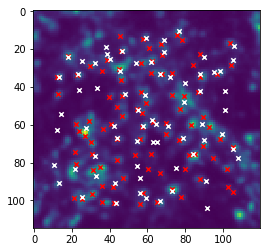

In [70]:
#Simhal
prob = 1.-dognet.baselines.probabilistic_synapse_segmentation(x[0:1],x[1:2],max_size=5,
                                                              window_size=3,conf_threshold=0.76, base_threshold=0.01)
r = (prob-prob.min())/(prob.max()-prob.min())

fpr, tpr, thresholds = roc_curve( y_gt.flatten(),r[0].flatten())
xx,yy,_ = dognet.find_peaks(r[0],5,minval=0.0)
pts = np.array([yy,xx]).transpose(1,0)
print(auc(fpr, tpr),pts.shape)
#print(dognet.get_metric(gt_pts,pts,s=3))
prec,rec,f1,_ = dognet.get_metric(gt_pts,pts,s=2)
print(f1,prec,rec)
plt.imshow(rep31_anno[0].image[0])
plt.scatter(xs,ys,s=20,c='r',marker='x',zorder=10)  
plt.scatter(yy,xx,s=20,c='w',marker='x',zorder=10)  

In [9]:
def get_random(repos,size,margin):
    xxx = []
    yyy = []
    pts = []
    nsamples = np.random.randint(1,len(repos))
    for n in range(nsamples):
        rep_id = np.random.randint(0,len(repos))
        xx = (np.random.randint(0,repos[rep_id].image.shape[1]-size[0]))
        yy = (np.random.randint(0,repos[rep_id].image.shape[2]-size[1]))

        xxx.append(normalize(repos[rep_id].image[:,int(xx):int(xx+size[0]),int(yy):int(yy+size[1])],get_normparams(rep21.data)))
        yyy.append(repos[rep_id].labels[int(xx):int(xx+size[0]),int(yy):int(yy+size[1])])
        pts.append(np.array([[x-yy,y-xx] for x,y in zip(repos[rep_id].x,repos[rep_id].y) if 
                             (x>yy+margin and x<yy+size[1]-margin and y>xx+margin and y<xx+size[0]-margin)]))
    return xxx, yyy, pts
    
def reset_net(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0., 2.5)
            
def trials(nets,sz,nrep,anno):
    result = []
    for s in sz:
        print('size:',s)
        for i in range(nrep):

            x,y,pt = get_random(anno,(s,s),5)
            
            
            gen = dognet.create_generator(x,y,size=(64,64))
            for n in nets:
                #reset_net(n)
                #n = dognet.SimpleIsotropic(len(req_channels),11,4,learn_amplitude=False)
                n.weights_init()
                               
                n,errors =dognet.train_routine(n.cuda(),gen,n_iter=3000,margin=5,verbose=False)                    
                f1,pre,re = estimate(n,rep31_anno)
                result.append([n.__class__,dognet.get_n_params(n),np.concatenate(pt).shape[0]]+list([f1,pre,re]))
                print(i,' n ex: ',np.concatenate(pt).shape[0],f1)
               
            
                
    df = pd.DataFrame(result)
    df.columns = ['name','#','# ex','f1','precision','recall']
    df.to_csv('prism_results_examples_ex_matt.csv')
    print(df)
    

In [8]:
def examples_benchmark(networks,repos,sizes,name,norm_params = get_normparams(rep21.data)):
     
    result = []
    for s in sizes:
        data =[]
        labels = []
        examples = 0
        for r in repos[:s[2]]:
            print(r.image.shape,s)
            xbeg = r.image.shape[1]/2-s[0]/2
            xend = r.image.shape[1]/2+s[0]/2
            ybeg = r.image.shape[2]/2-s[1]/2
            yend = r.image.shape[2]/2+s[1]/2
            data.append(normalize(r.image,norm_params)[:,
                                                       xbeg:xend,
                                                       ybeg:yend])
            labels.append(r.labels[xbeg:xend,
                                   ybeg:yend])
            pts = np.array([[x-ybeg,y-xbeg] for x,y in zip(r.x,r.y) if (x>ybeg and x<yend-1 and y>xbeg and y<xend-1)])
            examples += pts.shape[0]
        
        
        print(examples)
        gen = dognet.create_generator( data,labels)
        for n in networks:
            net,errors =dognet.train_routine(n.cuda(),gen,n_iter=3000,margin=3)
            result.append([net.__class__,dognet.get_n_params(net),examples]+list(estimate(net,rep31_anno)))
            
    df = pd.DataFrame(result)
    df.columns = ['name','#','# ex','f1','precision','recall']
    df.to_csv('prism_results_examples'+name+'.csv')
    print(df)
           

In [32]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

baselines = [dognet.baselines.Direct(3,3),
       dognet.baselines.FCN(3,4),
       dognet.baselines.FCN(3,3),      
       dognet.baselines.U_net(3,2),
       dognet.baselines.U_net(3,3)]

deepdogs = [
            dognet.SimpleIsotropic(3,15,2),
       dognet.SimpleAnisotropic(3,15,2),
       dognet.DeepAnisotropic(3,15,3,2,learn_amplitude=False),
       dognet.DeepIsotropic(3,15,3,2,learn_amplitude=False), 
            ]

# baselines = [dognet.baselines.FCN(len(req_channels),4,3),
#             dognet.baselines.FCN(len(req_channels),2,2),
#             dognet.baselines.Unet(len(req_channels),1,y=1),
#             dognet.baselines.Unet(len(req_channels),1,y=3)]

# deepdogs = [
#             dognet.DeepAnisotropic(len(req_channels),9,4,3,learn_amplitude=False),
#             dognet.DeepIsotropic(len(req_channels),11,4,3,learn_amplitude=False),  
#             dognet.SimpleAnisotropic(len(req_channels),11,12,learn_amplitude=False),
#             dognet.SimpleIsotropic(len(req_channels),11,12,learn_amplitude=False)
#             ]

# dogs = [
#             dognet.DeepAnisotropic(len(req_channels),11,4,2,learn_amplitude=False),
#             dognet.DeepIsotropic(len(req_channels),11,4,2,learn_amplitude=False),  
#             dognet.SimpleAnisotropic(len(req_channels),11,4,learn_amplitude=False),
#             dognet.SimpleIsotropic(len(req_channels),11,4,learn_amplitude=False)
#             ]


            
def run_benchmark(networks,name,gen,nrep=0):
    result = []
    for n in networks:
        reset_net(n)
        net,errors =dognet.train_routine(n.cuda(),gen,n_iter=3000,margin=5,lr=0.001,loss='softdice',verbose=False)
        result.append([net.__class__,dognet.get_n_params(net)]+list(estimate(net,rep31_anno,s=3.)))
    df = pd.DataFrame(result)
    df.columns = ['name','#','f1','precision','recall','auc']
    df.to_csv('prism_results_{}{}.csv'.format(name,nrep))
    
gen = dognet.create_generator([normalize(r.image,get_normparams(rep21.data)) for r in rep21_anno[:2]],
                                                 [l.labels for l in rep21_anno[:2]])

for nrep in range(4):
    run_benchmark(baselines+deepdogs,"all",gen,nrep)

In [71]:
csvs = [pd.read_csv('prism_results_all{}.csv'.format(i)) for i in range(3)]
df_concat = pd.concat(csvs)
df_concat.groupby(level=0).mean()
#df_concat.groupby(level=0).std()

,Unnamed: 0,#,f1,precision,recall,auc
0,0,370,0.78,0.81,0.77,0.88
1,1,2725,0.79,0.74,0.86,0.84
2,2,1558,0.83,0.84,0.82,0.87
3,3,791,0.75,0.79,0.72,0.85
4,4,1696,0.69,0.72,0.69,0.65
5,5,28,0.66,0.53,0.89,0.88
6,6,46,0.78,0.70,0.89,0.90
7,7,130,0.69,0.59,0.82,0.74
8,8,76,0.84,0.87,0.81,0.91
